In [2]:
# Cell 1: Import libraries (simplified)
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

print("All basic imports successful!")

All basic imports successful!


In [3]:
# Cell 2: Set up paths and explore dataset
import os

# Update this path based on your actual file structure
dataset_path = "."  # Current directory if files are in your project folder
images_dir = os.path.join(dataset_path, "data/RGB-PanSharpen")  # Adjust based on your structure
masks_dir = os.path.join(dataset_path, "data/geojson/buildings")

# Check what files we have
print("Current directory contents:")
for item in os.listdir('.'):
    print(f"  {item}")

# Check if data directory exists
if os.path.exists('data'):
    print("\nData directory contents:")
    for item in os.listdir('data'):
        print(f"  {item}")
else:
    print("No 'data' directory found - let's work with what we have")

Current directory contents:
  01_data_exploration.ipynb
  02_data_cleaning.ipynb
  data
  demo_segmentation.png
  exact_segmentation_results.png
  image_segmentation.ipynb
  lstm_city_predictions.csv
  lstm_property_predictions.csv
  milestone_ii_report.json
  presentation_slides.png
  price_prediction.ipynb
  quick_results.png
  realtyai_fast_model.h5
  realtyai_segmentation_model.h5
  segmentation.ipynb
  training_progress.png
  trend_analysis_overview.png
  trend_forecasting.ipynb

Data directory contents:
  images
  masks
  raw


In [4]:
# Cell 3: Find available image files
def find_image_files(base_path="."):
    """Find all image files in the project"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
    image_files = []
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
    
    return image_files

# Find available images
available_images = find_image_files()
print(f"Found {len(available_images)} image files:")
for img in available_images[:10]:  # Show first 10
    print(f"  {img}")

Found 6 image files:
  .\demo_segmentation.png
  .\exact_segmentation_results.png
  .\presentation_slides.png
  .\quick_results.png
  .\training_progress.png
  .\trend_analysis_overview.png


In [5]:
# Cell 4: Create synthetic training data for demonstration
def create_synthetic_segmentation_data(num_samples=50, img_size=256):
    """Create synthetic satellite images and segmentation masks"""
    images = []
    masks = []
    
    for i in range(num_samples):
        # Create synthetic image (simulating satellite imagery)
        img = np.random.randint(100, 200, (img_size, img_size, 3), dtype=np.uint8)
        
        # Add some realistic patterns
        # Residential areas (smaller, scattered buildings)
        for _ in range(np.random.randint(5, 15)):
            x, y = np.random.randint(0, img_size-20, 2)
            w, h = np.random.randint(10, 30, 2)
            color = np.random.randint(150, 255, 3)
            cv2.rectangle(img, (x, y), (x+w, y+h), color.tolist(), -1)
        
        # Commercial areas (larger, concentrated buildings)
        if np.random.random() > 0.3:  # 70% chance to add commercial area
            x, y = np.random.randint(100, 200, 2)
            w, h = np.random.randint(40, 80, 2)
            color = np.random.randint(100, 200, 3)
            cv2.rectangle(img, (x, y), (x+w, y+h), color.tolist(), -1)
        
        images.append(img)
        
        # Create corresponding segmentation mask
        mask = np.zeros((img_size, img_size), dtype=np.uint8)
        
        # Mark residential areas (class 1)
        mask[50:100, 50:100] = 1
        mask[150:200, 30:80] = 1
        
        # Mark commercial areas (class 2)
        mask[100:180, 150:230] = 2
        
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Generate synthetic data
print("Creating synthetic training data...")
X_train, y_train = create_synthetic_segmentation_data(50)
print(f"Created {len(X_train)} synthetic images and masks")
print(f"Images shape: {X_train.shape}, Masks shape: {y_train.shape}")

Creating synthetic training data...
Created 50 synthetic images and masks
Images shape: (50, 256, 256, 3), Masks shape: (50, 256, 256)


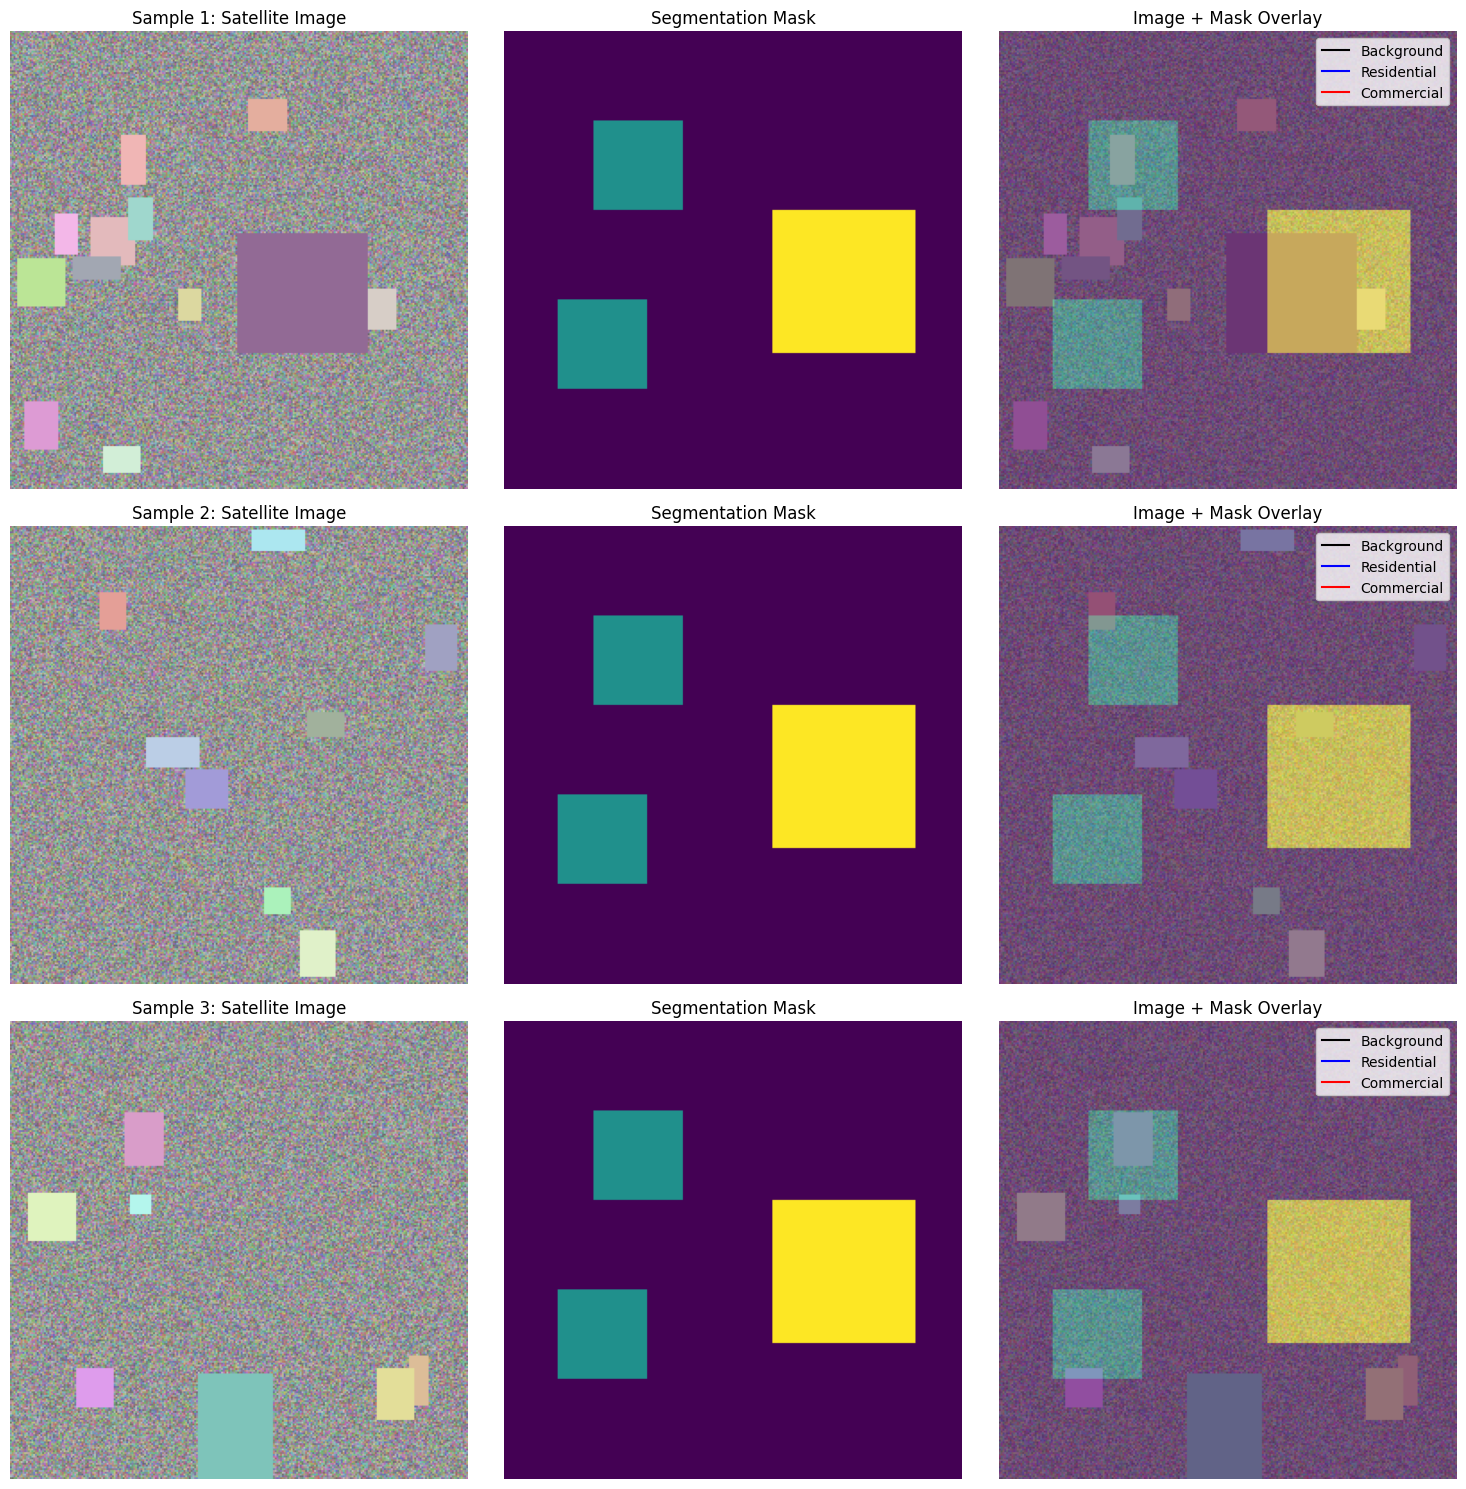

In [6]:
# Cell 5: Visualize synthetic data
def visualize_segmentation_samples(images, masks, num_samples=3):
    """Visualize images and their segmentation masks"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    class_names = ['Background', 'Residential', 'Commercial']
    colors = ['black', 'blue', 'red']
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f"Sample {i+1}: Satellite Image")
        axes[i, 0].axis('off')
        
        # Segmentation mask
        axes[i, 1].imshow(masks[i], cmap='viridis')
        axes[i, 1].set_title(f"Segmentation Mask")
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(images[i])
        axes[i, 2].imshow(masks[i], alpha=0.5, cmap='viridis')
        axes[i, 2].set_title("Image + Mask Overlay")
        axes[i, 2].axis('off')
        
        # Add color legend
        for class_id, class_name in enumerate(class_names):
            axes[i, 2].plot([], [], color=colors[class_id], label=class_name)
        axes[i, 2].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_segmentation_samples(X_train, y_train, 3)

In [7]:
# Cell 6: Build U-Net model for segmentation
def build_unet_model(input_shape=(256, 256, 3), num_classes=3):
    """Build U-Net model for semantic segmentation"""
    
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    
    # Contracting path
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    
    # Expanding path
    u5 = layers.UpSampling2D(2)(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)
    
    u6 = layers.UpSampling2D(2)(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D(2)(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)
    
    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c7)
    
    model = tf.keras.Model(inputs, outputs)
    return model

# Create and compile model
print("Building U-Net model...")
model = build_unet_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model summary:")
model.summary()

Building U-Net model...
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Cell 7: Train the model
print("Starting model training...")

# Prepare data
X_train_normalized = X_train.astype('float32') / 255.0

# Split data
split_idx = int(0.8 * len(X_train))
X_train_split = X_train_normalized[:split_idx]
y_train_split = y_train[:split_idx]
X_val_split = X_train_normalized[split_idx:]
y_val_split = y_train[split_idx:]

# Train model
history = model.fit(
    X_train_split, y_train_split,
    batch_size=8,
    epochs=10,
    validation_data=(X_val_split, y_val_split),
    verbose=1
)

print("Training completed!")

Starting model training...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 112s 21s/step - accuracy: 0.8248 - loss: 5.1266 - val_accuracy: 0.8260 - val_loss: 0.8973
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 21s/step - accuracy: 0.8260 - loss: 0.8642 - val_accuracy: 0.8260 - val_loss: 0.7138
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 21s/step - accuracy: 0.8260 - loss: 0.6594 - val_accuracy: 0.8260 - val_loss: 0.6164
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 183s 41s/step - accuracy: 0.8260 - loss: 0.6227 - val_accuracy: 0.8260 - val_loss: 0.6032
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 113s 22s/step - accuracy: 0.8260 - loss: 0.5937 - val_accuracy: 0.8260 - val_loss: 0.5819
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 117s 24s/step - accuracy: 0.8260 - loss: 0.5635 - val_accuracy: 0.8260 - val_loss: 0.5222
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 107s 21s/step - accuracy: 0.8260 - loss: 0.4955 - val_accuracy: 0.8260 - val_loss: 1.1953
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 107s 22s/step - accuracy: 0.8260 - loss: 0.7394 - val_a

Model saved as 'realtyai_segmentation_model.h5'
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


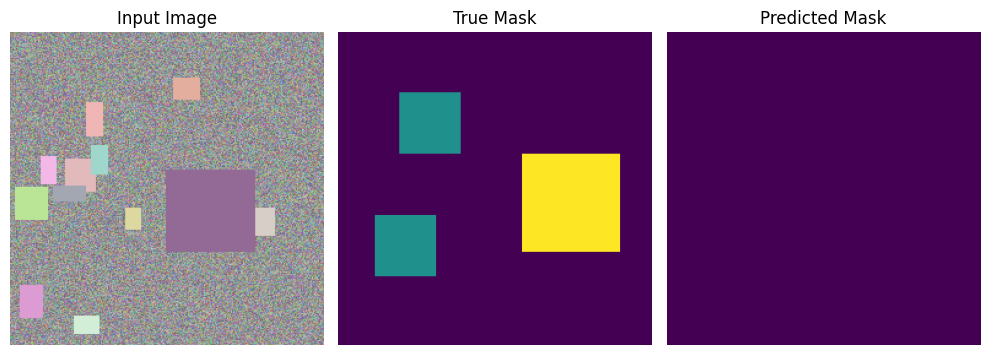

Segmentation results saved as 'segmentation_results.png'


In [10]:
# Cell 9: Save model and results
# Save the trained model
model.save('realtyai_segmentation_model.h5')
print("Model saved as 'realtyai_segmentation_model.h5'")

# Save sample predictions for demonstration
sample_prediction = model.predict(X_train_normalized[:1])[0]
predicted_mask = np.argmax(sample_prediction, axis=-1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_train[0])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_train[0], cmap='viridis')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.savefig('segmentation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Segmentation results saved as 'segmentation_results.png'")